## 밑바닥부터 시작하는 딥러닝(Deep Learning from Scratch) 챕터별 예제코드 정리 
예제코드가 기본이나 정확히 일치하지는 않습니다. 개인적으로 모든 코드들을 문서화하되 너무 기본적인 내용은 제외하거나 나름대로 더 필요하다고 생각되는 내용은 추가하였습니다. 같은 내용을 다른 방식으로 구현하는 경우도 있습니다.
## Chapter 6. 학습 관련 기술들
### 6.5 Hyperparameter optimization
neuralnet에서 learning rate, hidden layer의 수, hidden node의 수, Dropout의 ratio 같은 것들은 Hyperparameter로 validation data를 활용하여 최적의 값을 찾아야한다. 각 data의 용도는 아래와 같이 정리할 수 있다.

    Training data : parameter learning
    Validation data : hyperparameter optimize 
    Test data : evaluation model  
  
Validation data로 최적의 hyperparameter를 찾은 이후에는 보통 Validation data를 재활용하지않고 버린다. 아래의 예제는 learning rate와 weight decay의 hyperparameter인 lambda를 Random search로 찾는 예제이다. (neuralnet의 hyperparameter optimization에서는 Random search가 더 좋다고 알려져있다. 자세한 내용은 아래의 링크를 참고)  

cs231n neural network part3 : http://cs231n.github.io/neural-networks-3/

![Alt text](http://i.imgur.com/4ylg97c.jpg)

### Load modules & library

In [1]:
import numpy as np
import matplotlib.pylab as plt
import sys, os
sys.path.append('C:/Users/KBS/PycharmProjects/Deep_learning_scratch')
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

### Split training data into training data and validation data

In [2]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

### Function for Experiment 

In [3]:
def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()
    return trainer.test_acc_list, trainer.train_acc_list

### Random search for hyperparameter

In [4]:
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    #print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

### Visualization
아래의 그림에서 점선은 Training data에 대한 Accuracy를 나타내며 실선은 Validation data에 대한 Accuracy를 나타낸다. Best 1 ~ Best 5 정도까지는 해당하는 hyperparameter가 적절함을 볼 수 있고 해당 learning rate의 구간은 대략 0.001 ~ 0.01, weight decay의 구간은 대략 1e-7 ~ 1e-5임을 볼 수 있고, 다음 Random search를 시행시 해당 구간으로 다시 search하면 충분하다. 

Best-1(val acc:0.75) | lr:0.009525447793811667, weight decay:2.899372922975804e-07
Best-2(val acc:0.75) | lr:0.006978663802464487, weight decay:7.627343431511504e-07
Best-3(val acc:0.74) | lr:0.009589377071672749, weight decay:3.948015785281296e-05
Best-4(val acc:0.73) | lr:0.006821354578657186, weight decay:2.7505784678146656e-05
Best-5(val acc:0.53) | lr:0.0034688671146546357, weight decay:1.28439246839687e-05
Best-6(val acc:0.43) | lr:0.002834964960068361, weight decay:2.3031127891517224e-06
Best-7(val acc:0.42) | lr:0.002441598984054523, weight decay:1.1546084365256328e-07
Best-8(val acc:0.38) | lr:0.0021024620936701535, weight decay:1.1922530083848812e-08
Best-9(val acc:0.35) | lr:0.0016216782920936514, weight decay:1.7474200036620757e-06
Best-10(val acc:0.35) | lr:0.0021455230397289878, weight decay:1.5584340873341576e-07
Best-11(val acc:0.33) | lr:0.002358572088001542, weight decay:1.9171415826474763e-06
Best-12(val acc:0.32) | lr:0.0015283650560183185, weight decay:7.1875376378

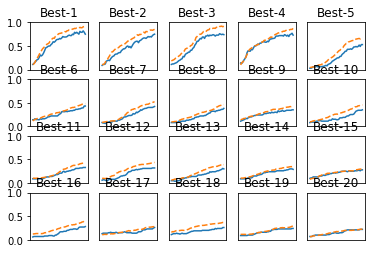

In [5]:
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break
plt.show()